Pendant l'entraînement d'un réseau neuronal, la régularisation par dropout consiste à désactiver aléatoirement un certain pourcentage de neurones dans une couche donnée à chaque itération. Voici une représentation mathématique de ce processus :

1. Pour chaque exemple d'entraînement dans un lot (mini-batch), on crée une matrice de masquage $ M $ de la même taille que la couche, où chaque élément est soit 0, soit 1, selon une distribution de Bernoulli avec une probabilité $ p $ (la probabilité de dropout). $ M_{ij} = 0 $ avec une probabilité $ p $, et $ M_{ij} = 1 $ avec une probabilité $ 1 - p $.

2. On multiplie les activations de la couche par la matrice de masquage $ M $ :

$$
\text{Sortie} = \text{Activation} \times M
$$

Durant l'évaluation ou l'inférence (lorsque le modèle est utilisé pour des prédictions et non pour l'entraînement), on n'applique généralement pas le dropout car on veut utiliser l'ensemble complet du réseau. Cependant, pour compenser l'activation accrue pendant l'entraînement due au dropout, on doit mettre à l'échelle les activations pendant l'inférence. On multiplie habituellement les activations par $ 1 - p $ (dropout inversé) :

$$
\text{Sortie} = \text{Activation} \times (1 - p)
$$

Cette mise à l'échelle aide à maintenir la valeur attendue des activations plus proche de ce qu'elles seraient pendant l'entraînement.

Le dropout contribue à prévenir le surapprentissage en introduisant du bruit pendant l'entraînement, rendant le réseau plus robuste et moins dépendant de neurones spécifiques pour faire des prédictions. Il crée en effet un ensemble de différents réseaux en désactivant aléatoirement des unités, forçant ainsi le réseau à apprendre des caractéristiques plus robustes.

En résumé :
- Pendant l'entraînement : On multiplie les activations par un masque $ M $ et on met à l'échelle par $ 1/(1 - p) $ pour compenser les neurones désactivés.
- Pendant l'évaluation : On multiplie les activations par $ 1 - p $ pour maintenir les valeurs attendues et on n'applique pas le dropout.

In [28]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [29]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [30]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self,).__init__()
        self.fc1 = nn.Linear(28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 10)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [31]:
# Affichage des poids à la fin de l'entraînement pour chaque cas
def plot_weights(weights, title, ax):
                im = ax.imshow(weights, cmap='jet')
                ax.set_title(title)
                ax.axis('off')
                plt.colorbar(im, ax=ax)

def display_weights(model_state_dict, description):
                model = MLP().to(device)
                model.load_state_dict(model_state_dict)
                model.eval()

                fig, axs = plt.subplots(2, 2, figsize=(12, 8))

                plot_weights(model.fc1.weight.cpu().detach().numpy(), f'Couche 1 ({description})', axs[0, 0])
                plot_weights(model.fc2.weight.cpu().detach().numpy(), f'Couche 2 ({description})', axs[0, 1])
                plot_weights(model.fc3.weight.cpu().detach().numpy(), f'Couche 3 ({description})', axs[1, 0])
                plot_weights(model.fc4.weight.cpu().detach().numpy(), f'Couche 4 ({description})', axs[1, 1])

                plt.tight_layout()
                plt.show()


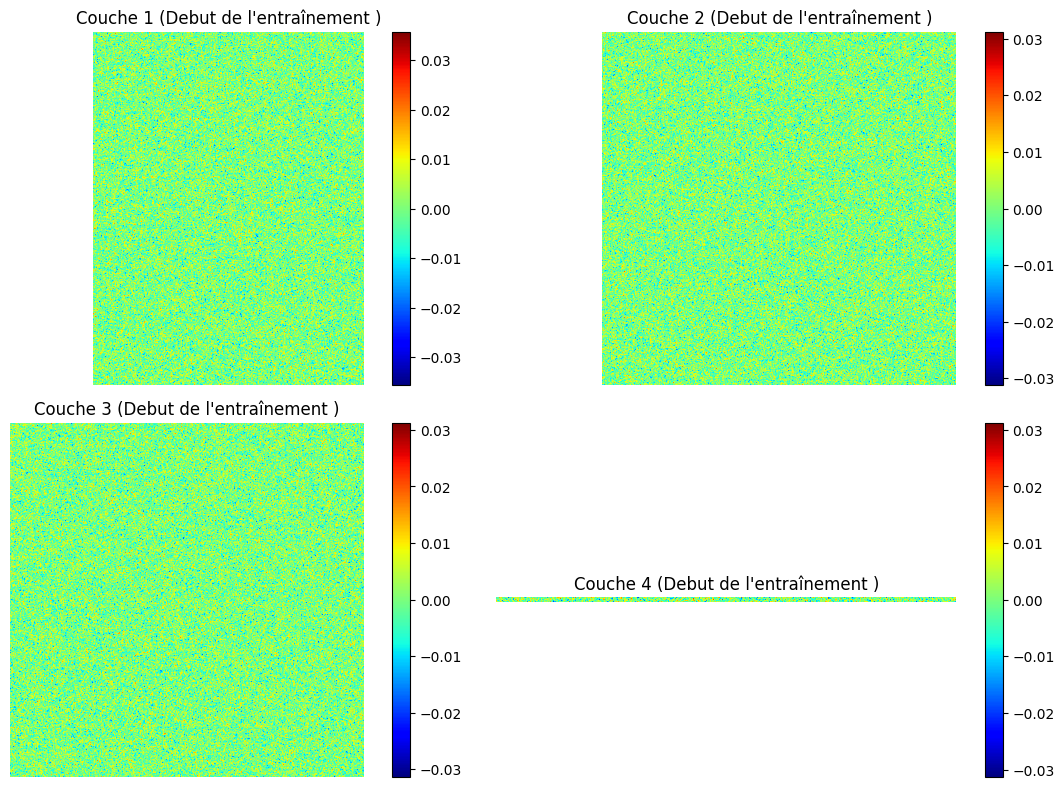

In [33]:
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
display_weights(model.state_dict(), "Debut de l'entraînement ")

In [34]:
best_accuracy = 0
best_model_state = None

In [35]:


print(f"Entraînement du modèle")

for epoch in range(10):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch [{epoch + 1}/10], Précision sur l'ensemble de validation : {accuracy:.2f}%")


        if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = model.state_dict()






Entraînement du modèle sans dropout
Epoch [1/10], Précision sur l'ensemble de validation : 83.43%
Epoch [2/10], Précision sur l'ensemble de validation : 85.89%
Epoch [3/10], Précision sur l'ensemble de validation : 85.10%
Epoch [4/10], Précision sur l'ensemble de validation : 86.33%
Epoch [5/10], Précision sur l'ensemble de validation : 87.30%
Epoch [6/10], Précision sur l'ensemble de validation : 87.11%
Epoch [7/10], Précision sur l'ensemble de validation : 87.45%
Epoch [8/10], Précision sur l'ensemble de validation : 86.97%
Epoch [9/10], Précision sur l'ensemble de validation : 88.45%
Epoch [10/10], Précision sur l'ensemble de validation : 87.30%


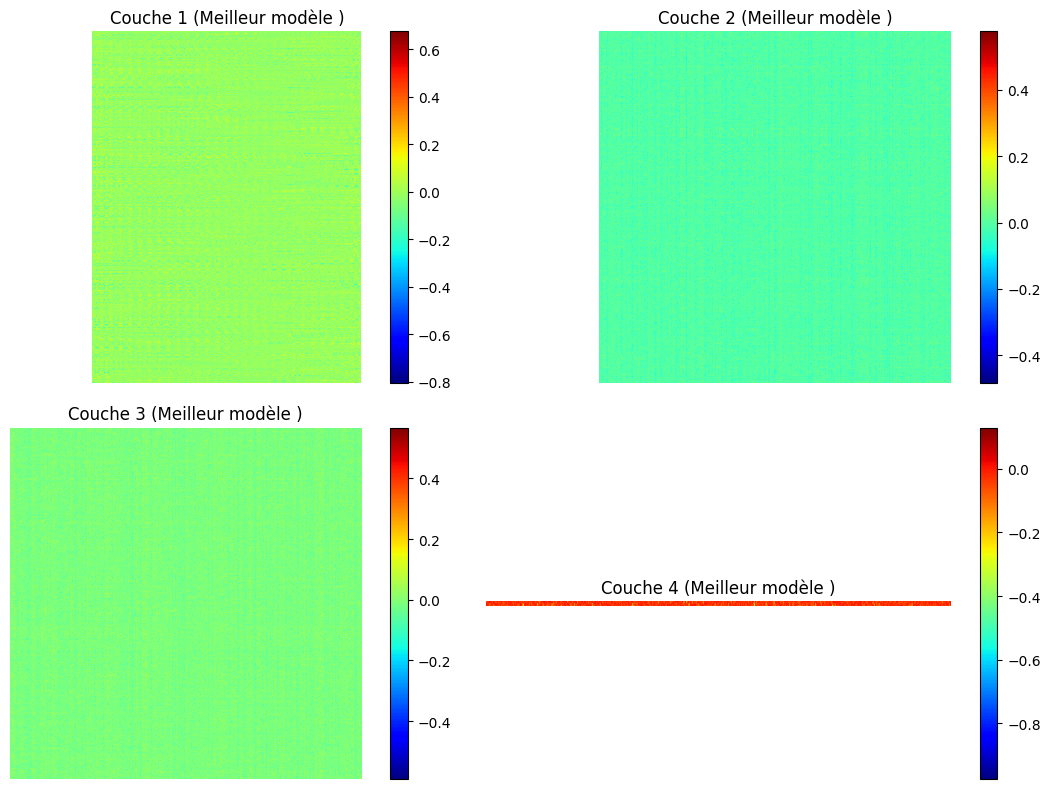

In [36]:
display_weights(best_model_state, f"Meilleur modèle ")
